<a href="https://colab.research.google.com/github/rht6226/InnoHAR-NeuralNet/blob/master/Conv_LSTM_based_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Conv-LSTM based Model

In this module we will be training a model which uses the CNN-LSTM Architecture for Human Activity recognition on UCI HAR Mobile Dataset. 

It is a further extension of the CNN LSTM. The idea is to perform the convolutions of the CNN (e.g. how the CNN reads the input sequence data) as part of the LSTM.

This combination is called a Convolutional LSTM, or ConvLSTM for short, and like the CNN LSTM is also used for spatio-temporal data.

Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves.



In [1]:
# Imports
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

## Loading the dataset

In [2]:
# Get class from file
from drive.MyDrive.InnoHAR.DatasetLoader import UciMobileDataset

In [3]:
uci = UciMobileDataset(filepath='/content/drive/MyDrive/InnoHAR/ProcessedDataset/')
uci.summary()

UCI Human Activity Recognition Dataset: 
Shape of training data = X:(7352, 128, 9), y: (7352, 6)
Shape of testing data = X:(2947, 128, 9), y: (2947, 6)


## Creating the Model

### Reshaping  the data

In [4]:
# Define variables
n_timesteps, n_features, n_outputs = uci.trainX.shape[1], uci.trainX.shape[2], uci.trainy.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
trainX = uci.trainX.reshape((uci.trainX.shape[0], n_steps, 1, n_length, n_features))
testX = uci.testX.reshape((uci.testX.shape[0], n_steps, 1, n_length, n_features))

In [5]:
print("Reshaped the trainX data from {} to : {}".format(uci.trainX.shape, trainX.shape))
print("Reshaped the testX data from {} to : {}".format(uci.testX.shape, testX.shape))

Reshaped the trainX data from (7352, 128, 9) to : (7352, 4, 1, 32, 9)
Reshaped the testX data from (2947, 128, 9) to : (2947, 4, 1, 32, 9)


### Model Creation

In [6]:
# imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, ConvLSTM2D, Flatten
from keras.utils.vis_utils import plot_model

In [7]:
def get_convLSTM_model(trainX, trainy):
    n_steps, n_length, n_features = trainX.shape[1], trainX.shape[3], trainX.shape[4]
    n_outputs = trainy.shape[1]
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [8]:
# Summarising the model
model = get_convLSTM_model(trainX, uci.trainy)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 30, 64)         56320     
_________________________________________________________________
dropout (Dropout)            (None, 1, 30, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 249,026
Trainable params: 249,026
Non-trainable params: 0
_________________________________________________________________


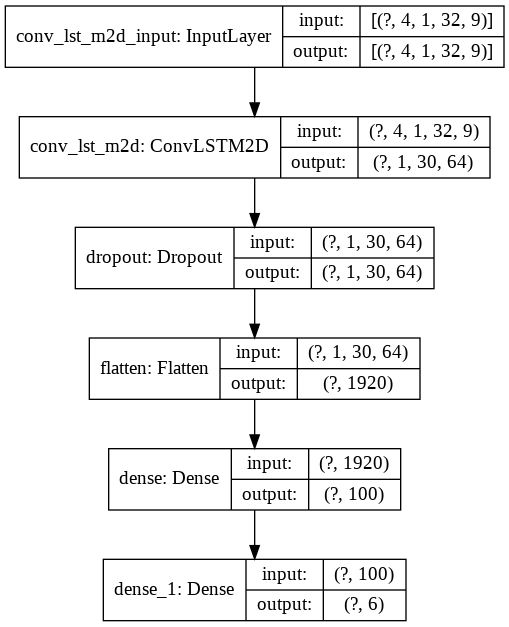

In [9]:
plot_model(model=model, show_layer_names=True, show_shapes=True)

## Training the Models

Only one instance of a trained model cannot be used to determine the model performance. Hence we will be training Multiple instances of the same ConvLSTM model and then we will find out the average accuracy.

In [10]:
def train_models(X=trainX, y=uci.trainy, num_instances=50, verbose=1, epochs=25, batch_size=64, valid_data = (testX, uci.testy)):

    # Here we will store all the models
    modelList = []

    # Training multiple models at the same time for finding average accuracy
    for i in range(num_instances):
        print("\n<========== Now training model - {} ...... =======>".format(i))

        model = get_convLSTM_model(X, y)
        history = model.fit(X, y, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=valid_data)

        print("<==================================================>\n")

        # Finding accuracy
        _, accuracy = model.evaluate(valid_data[0], valid_data[1], batch_size=32, verbose=0)

        modelList.append({
            "model": model,
            "history": history,
            "accuracy": accuracy
        })

    return modelList

In [11]:
epochs, batch_size = 25, 64
modelList = train_models(epochs=epochs, batch_size=batch_size)


<========== Now training model - 0 ...... =======>
Epoch 1/25
115/115 [==============================] - 3s 29ms/step - loss: 0.6060 - accuracy: 0.7580 - val_loss: 0.6324 - val_accuracy: 0.8056
Epoch 2/25
115/115 [==============================] - 3s 25ms/step - loss: 0.2217 - accuracy: 0.9161 - val_loss: 0.5112 - val_accuracy: 0.8789
Epoch 3/25
115/115 [==============================] - 3s 26ms/step - loss: 0.1508 - accuracy: 0.9391 - val_loss: 0.5039 - val_accuracy: 0.8863
Epoch 4/25
115/115 [==============================] - 3s 25ms/step - loss: 0.1319 - accuracy: 0.9445 - val_loss: 0.5801 - val_accuracy: 0.8873
Epoch 5/25
115/115 [==============================] - 3s 25ms/step - loss: 0.1204 - accuracy: 0.9491 - val_loss: 0.5650 - val_accuracy: 0.8958
Epoch 6/25
115/115 [==============================] - 3s 29ms/step - loss: 0.1327 - accuracy: 0.9480 - val_loss: 0.5750 - val_accuracy: 0.8931
Epoch 7/25
115/115 [==============================] - 3s 30ms/step - loss: 0.1123 - accura

# Compare different instances

We will compare the different instances of trained model to find the one which gives the best performance. We will also find the average accuracy for the trained models.

In [12]:
# Imports
import matplotlib.pyplot as plt
from statistics import mean 

In [13]:
def plot_accuracies(modelList, modelName, figureSize=[8, 8]):
    accuracies = []
    for modelDict in modelList:
        accuracies.append(modelDict['accuracy'])
    mean_accuracy = mean(accuracies)
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(accuracies)
    plt.axhline(y=mean_accuracy, color='r', linestyle='-')
    plt.title('Model accuracy for different instances of - {}'.format(modelName))
    plt.ylabel('accuracy')
    plt.xlabel('Instance #')
    plt.legend(['Instance Accuracy', 'Mean Accuracy'], loc='lower right')
    plt.show()
    
    print("\n\nThe average accuracy of this model was found out to be: {}".format(mean_accuracy))

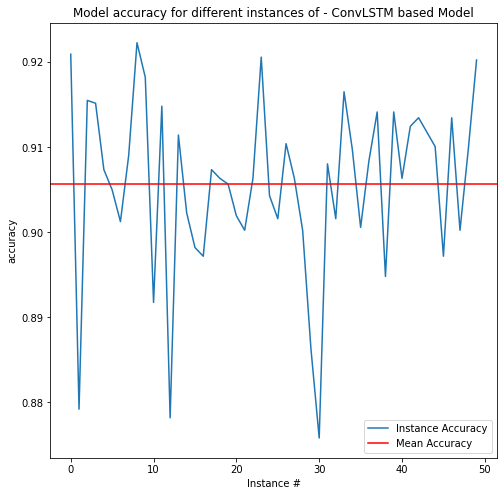



The average accuracy of this model was found out to be: 0.9056871366500855


In [14]:
plot_accuracies(modelList, modelName='ConvLSTM based Model')

## Selecting Model closest to Mean

here we will be selecting a model instance whose performance is the closest to the mean accuracy. This will help us in comparision between various models.

In [15]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import get_average_model

In [16]:
model, history = get_average_model(modelList)

In [17]:
## Save Model
model.save('/content/drive/MyDrive/InnoHAR/SavedModels/ConvLSTM.h5')

## Plotting Accuracy and Losses

In [18]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import plot_model_accuracy, plot_model_loss

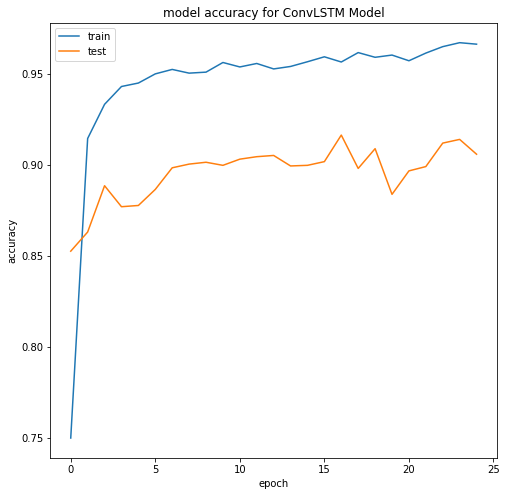

In [19]:
plot_model_accuracy('ConvLSTM Model', history=history)

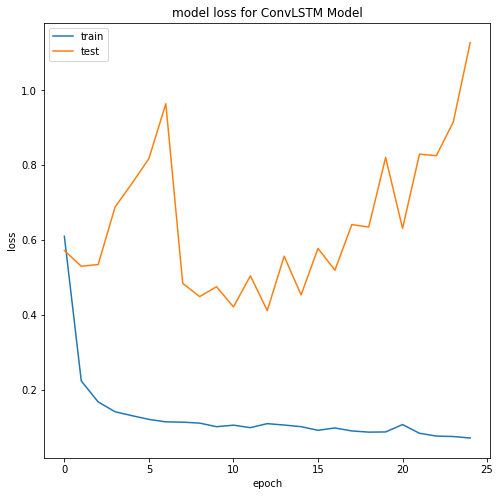

In [20]:
plot_model_loss('ConvLSTM Model', history=history)

## Plotting Confusion Matrix

In [23]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import plot_cm

Confusion matrix, without normalization


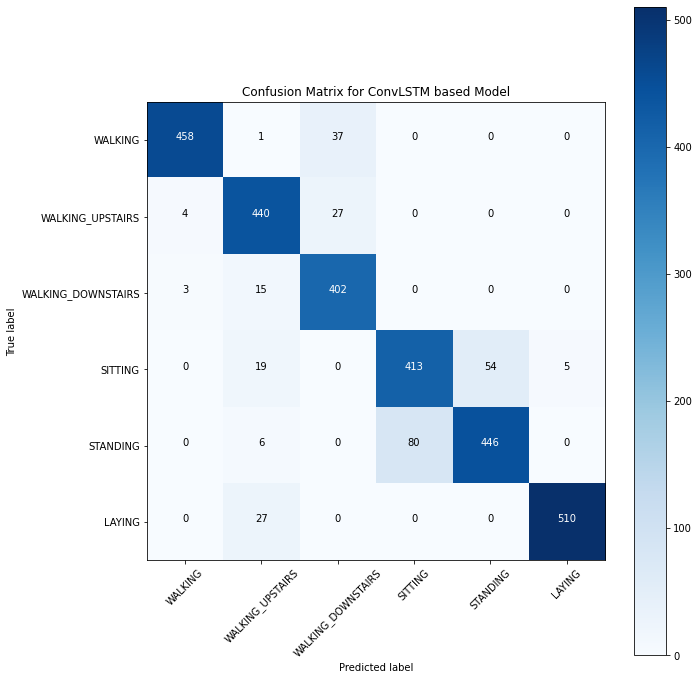

In [24]:
plot_cm(model, test_data=(testX, uci.testy), title='Confusion Matrix for ConvLSTM based Model')

## Classification Report

In [25]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import print_classification_report

In [27]:
print_classification_report(model, test_data=(testX, uci.testy), title='CNN-LSTM Model')

Classification Report for 'CNN-LSTM Model': 

                    precision    recall  f1-score   support

           WALKING    0.98495   0.92339   0.95317       496
  WALKING_UPSTAIRS    0.86614   0.93418   0.89888       471
WALKING_DOWNSTAIRS    0.86266   0.95714   0.90745       420
           SITTING    0.83773   0.84114   0.83943       491
          STANDING    0.89200   0.83835   0.86434       532
            LAYING    0.99029   0.94972   0.96958       537

          accuracy                        0.90567      2947
         macro avg    0.90563   0.90732   0.90548      2947
      weighted avg    0.90820   0.90567   0.90598      2947

